In [1]:
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import pylab as plt

In [2]:
df = pd.read_csv("D:\Academic\Y4S2\DSA4212\Assignment\songsDataset.csv", header=0, names=['userID','songID','rating'])

### Data Split

In [91]:
from sklearn.model_selection import train_test_split

total_size = len(df)
train_size = total_size * 8 // 10
test_size = total_size - train_size
partition_sizes = [train_size // 8] * 8 + [test_size // 2] * 2

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

partitions = [df_shuffled.iloc[i:i+size] for i, size in enumerate(partition_sizes)]

train_datasets = partitions[:8]
test_datasets = partitions[8:]

train_df = pd.concat(train_datasets, ignore_index=True)
test_df = pd.concat(test_datasets, ignore_index=True)

train_df.shape, test_df.shape

((1600000, 3), (400000, 3))

### Without Regularization

In [113]:
# Training MSE for naive mean model
np.mean((train_df['rating']-np.mean(train_df['rating']))**2)

2.4183402637749998

In [92]:
# Test MSE for naive mean model
np.mean((test_df['rating']-np.mean(train_df['rating']))**2)

2.4183413119500003

In [114]:
# Traing MSE for user mean model
np.mean(train_df.groupby('userID')['rating'].transform(lambda x: (x - x.mean())**2))

0.5756254378876151

In [95]:
# Test MSE for user mean model
from sklearn.metrics import mean_squared_error

user_mean = train_df.groupby('userID')['rating'].mean()
global_mean = train_df['rating'].mean()  # Global mean of train data as a fallback
test_df_user_mean = test_df.copy()
test_df_user_mean['predicted_rating'] = test_df_user_mean['userID'].map(user_mean).fillna(global_mean)
mean_squared_error(test_df_user_mean['rating'], test_df_user_mean['predicted_rating'])

0.5756581326783724

In [115]:
# Training MSE for song mean model
np.mean(train_df.groupby('songID')['rating'].transform(lambda x: (x - x.mean())**2))

1.5260623708575298

In [96]:
# Test MSE for song mean model
song_mean = train_df.groupby('songID')['rating'].mean()
test_df_song_mean = test_df.copy()
test_df_song_mean['predicted_rating'] = test_df_song_mean['songID'].map(song_mean).fillna(global_mean)
mean_squared_error(test_df_song_mean['rating'], test_df_song_mean['predicted_rating'])

1.5260944018532976

### With Regularization

### Mean-user

In [107]:
alpha_list = [1e-6, 1e-2, 1, 5, 10, 50, 100]
errors = []
for alpha in alpha_list:
    errors.append(np.mean(train_df.groupby('userID')['rating'].transform(lambda x: (x-1/(alpha+len(x))*(alpha*global_mean+sum(x)))**2)))

Text(0.5, 0, 'Alpha')

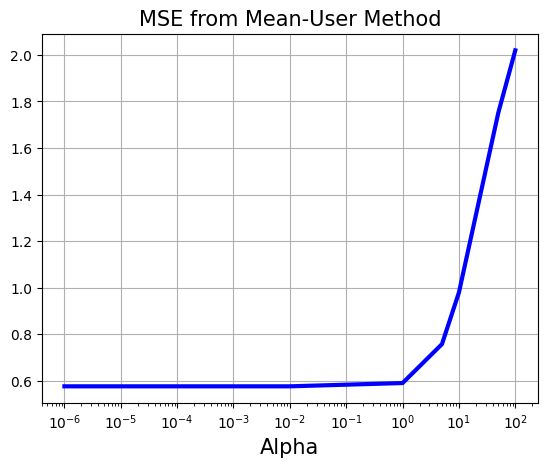

In [108]:
plt.plot(alpha_list, errors,'-',lw=3,color='blue')
plt.grid()
plt.xscale('log')
plt.title('MSE from Mean-User Method',fontsize=15)
plt.xlabel('Alpha',fontsize=15)

In [109]:
errors

[0.5756254378876328,
 0.5756271846268535,
 0.5897476045645291,
 0.7570442951980728,
 0.9790808591753206,
 1.751999797263354,
 2.0198653062692045]

### Mean-song

In [110]:
errors = []
for alpha in alpha_list:
    errors.append(np.mean(df.groupby('songID')['rating'].transform(lambda x: (x-1/(alpha+len(x))*(alpha*global_mean+sum(x)))**2)))

Text(0.5, 0, 'Alpha')

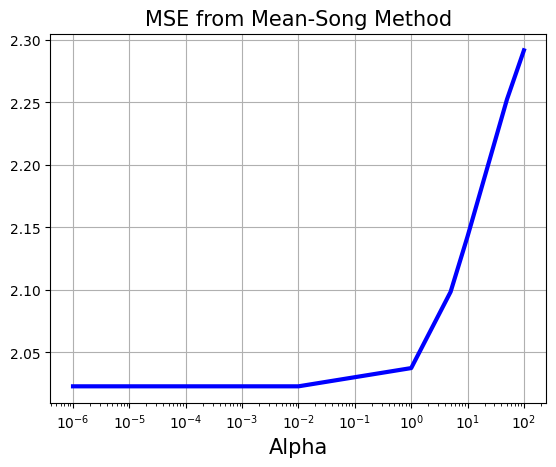

In [111]:
plt.plot(alpha_list, errors,'-',lw=3,color='blue')
plt.grid()
plt.xscale('log')
plt.title('MSE from Mean-Song Method',fontsize=15)
plt.xlabel('Alpha',fontsize=15)

In [112]:
errors

[2.02284104390864,
 2.0228449772996484,
 2.0374338753669643,
 2.0984151782433607,
 2.142788373477195,
 2.252369691531906,
 2.291642418784776]